### SOM Molecular Descriptors and Experimental Data

* this is a notebook that focues on molecular descriptors analysis 
* mordred descriptor is the package we implement here

In [33]:
from __future__ import print_function
import pandas as pd
import numpy as np
from sompy.sompy import SOMFactory

# import functions from images_gen
import images_gen
from images_gen import classify_by_group

import sklearn
import sklearn.cluster as cluster
from sklearn import preprocessing
import urllib3
from sklearn.externals import joblib
import glob
import random

import tfprop_sompy
from tfprop_sompy import tfprop_config
from tfprop_sompy import tfprop_vis
from tfprop_sompy import tfprop_analysis
import images_gen
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import matplotlib as mpl
import matplotlib.pyplot as plt
import images_gen
from images_gen import classify_by_group
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import pickle

### Load the Data

In [34]:
data = pd.read_csv(r"./data/compdata_classification_des.csv").set_index("ID No.")
# "Voc","Jsc","FF","Monomer","Mw","PDI","DP","HOMO","LUMO","Bandgap"
# DP is related to Mw, and Mw is one of the most important property in OPV research
# 
names = ["Voc (V)","Jsc (mA/cm2)","FF","Mw (kg/mol)", "HOMO (eV)"] #select essential experimental factors
sample = data.sample(400)
data.head(3)

C:\Users\jtz93\Anaconda3\envs\SOMenv\lib\site-packages\IPython\core\interactiveshell.py:3044: DtypeWarning: Columns (97,98,99,100,101,102,103,104,105,304,305,306,307,308,309,310,311,312,412,413,414,415,416,417,418,419,420,517,518,519,520,521,522,523,524,613,614,615,616,617,618,619,620,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799,800,801,802,803,804,805,806,807,808,809,810,811,812,813,861,869,877,885,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,924,925,926,927,928,929,930,931,932,933,934,1093,1096,1097,1098,1099,1100,1101,1102,1103,1104,1105,1106,1107,1108,1109,1110,1111,1112,

Nickname Ref. No  PCE_max  PCE_ave  Voc (V)  Jsc (mA/cm2)    FF  \
ID No.                                                                     
1       PBTTT-C14      S1     2.34     2.34     0.53          9.37  0.48   
2          PCDTBT      S2     3.60     3.60     0.89          6.92  0.63   
3         PCPDTBT      S3     5.12     5.12     0.61         15.73  0.53   

        Mw (kg/mol)  Mn (kg/mol)   PDI  ...  NumSaturatedHeterocycles  \
ID No.                                  ...                             
1              46.2         22.0  2.10  ...                         0   
2              73.0         37.0  1.97  ...                         0   
3              47.6         26.6  1.79  ...                         0   

        NumAliphaticHeterocycles  NumSpiroAtoms  NumBridgeheadAtoms  \
ID No.                                                                
1                              0              0                   0   
2                              0              0                   0   
3                              0              0                   0   

        NumAtomStereoCenters  NumUnspecifiedAtomStereoCenters   labuteASA  \
ID No.                                                                      
1                          0                                0  311.736973   
2                          0                                0  316.643277   
3                          2                                2  241.797891   

         tpsa  CrippenClogP  CrippenMR  
ID No.                                  
1        0.00      17.52384    225.366  
2       30.71      15.58234    226.976  
3       25.78      11.57764    170.141  

[3 rows x 1511 columns]

In [35]:
data.info()
sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1203 entries, 1 to 1203
Columns: 1511 entries, Nickname to CrippenMR
dtypes: bool(2), float64(834), int64(393), object(282)
memory usage: 13.9+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 400 entries, 975 to 1044
Columns: 1511 entries, Nickname to CrippenMR
dtypes: bool(2), float64(834), int64(393), object(282)
memory usage: 4.6+ MB


### Feature Selection

* Based on the original data, sort out the most significant ones
* 

### Loading dataframe used for SOM training

In [36]:
df = data[names]
sdf = sample[names]

df.columns = names
sdf.columns = names

df2 = df.as_matrix()
sdf2 = sdf.as_matrix()

df.head(5)

C:\Users\jtz93\Anaconda3\envs\SOMenv\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys
C:\Users\jtz93\Anaconda3\envs\SOMenv\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Voc (V)  Jsc (mA/cm2)    FF  Mw (kg/mol)  HOMO (eV)
ID No.                                                     
1          0.53          9.37  0.48         46.2       5.10
2          0.89          6.92  0.63         73.0       5.50
3          0.61         15.73  0.53         47.6       5.30
4          0.77         18.40  0.74         93.7       5.34
5          0.77         18.20  0.74         52.9       5.20

## SOM Model

* dump and load the model to save time 
* multiple models are exported
* models include:
    * compdata
    * with or without certain elements
    
* errors are exported below - topographic error and quantization error
* hyperparameter tuning
    * finetune len
    * roughtune len
    * finetune radius
    * roughtune radius


## Visualization of SOM Results in 2D 
* quantization error is too high compare to the given example of tfprop
    * check for std, mean, max, min, var and other statistical data

In [53]:
# mapsize should accomodate all data points
mapsize = (80,80)

# length here
# dlen = len(data)
# nnodes = mapsize[0]*mapsize[1]
# train_len = 200*nnodes/float(dlen)
# train_len = int(np.ceil(trainlen))

# radius here
# radiusin = max(mapsize)/float(6) if min(mapsize)!=1
# radiusfin = radiusin/float(10)
# radius = np.linspace(radiusin, radiusfin, trainlen)

sm = SOMFactory.build(df2, mapsize=mapsize, normalization='var',initialization='pca', component_names=names)
sm.train(
    n_job=4, 
    verbose='info',
    train_rough_len=None,
    train_rough_radiusin=None,
    train_rough_radiusfin=None,
    train_finetune_len=None,
    train_finetune_radiusin=None,
    train_finetune_radiusfin=None,
    train_len_factor=1
)

 Training...
 pca_linear_initialization took: 0.155000 seconds
 Rough training...
 radius_ini: 10.000000 , radius_final: 2.500000, trainlen: 160

 epoch: 1 ---> elapsed time:  0.919000, quantization error: 1.132103

 epoch: 2 ---> elapsed time:  0.954000, quantization error: 1.046402

 epoch: 3 ---> elapsed time:  0.955000, quantization error: 0.991464

 epoch: 4 ---> elapsed time:  0.982000, quantization error: 0.967871

 epoch: 5 ---> elapsed time:  0.953000, quantization error: 0.952769

 epoch: 6 ---> elapsed time:  0.998000, quantization error: 0.943649

 epoch: 7 ---> elapsed time:  0.997000, quantization error: 0.936145

 epoch: 8 ---> elapsed time:  1.003000, quantization error: 0.930287

 epoch: 9 ---> elapsed time:  0.986000, quantization error: 0.926093

 epoch: 10 ---> elapsed time:  0.972000, quantization error: 0.922582

 epoch: 11 ---> elapsed time:  0.993000, quantization error: 0.918468

 epoch: 12 ---> elapsed time:  1.027000, quantization error: 0.915200

 epoch: 13 

 epoch: 115 ---> elapsed time:  0.959000, quantization error: 0.662773

 epoch: 116 ---> elapsed time:  0.954000, quantization error: 0.659367

 epoch: 117 ---> elapsed time:  0.944000, quantization error: 0.655720

 epoch: 118 ---> elapsed time:  0.954000, quantization error: 0.651900

 epoch: 119 ---> elapsed time:  0.968000, quantization error: 0.648301

 epoch: 120 ---> elapsed time:  0.966000, quantization error: 0.644978

 epoch: 121 ---> elapsed time:  0.970000, quantization error: 0.641642

 epoch: 122 ---> elapsed time:  0.982000, quantization error: 0.638017

 epoch: 123 ---> elapsed time:  0.986000, quantization error: 0.634139

 epoch: 124 ---> elapsed time:  0.992000, quantization error: 0.630562

 epoch: 125 ---> elapsed time:  0.968000, quantization error: 0.626989

 epoch: 126 ---> elapsed time:  0.961000, quantization error: 0.623850

 epoch: 127 ---> elapsed time:  0.982000, quantization error: 0.620397

 epoch: 128 ---> elapsed time:  0.975000, quantization error: 0.

 epoch: 69 ---> elapsed time:  1.250000, quantization error: 0.385847

 epoch: 70 ---> elapsed time:  1.651000, quantization error: 0.384706

 epoch: 71 ---> elapsed time:  1.812000, quantization error: 0.383565

 epoch: 72 ---> elapsed time:  1.202000, quantization error: 0.382478

 epoch: 73 ---> elapsed time:  1.105000, quantization error: 0.381328

 epoch: 74 ---> elapsed time:  1.052000, quantization error: 0.380036

 epoch: 75 ---> elapsed time:  1.292000, quantization error: 0.378816

 epoch: 76 ---> elapsed time:  1.449000, quantization error: 0.377538

 epoch: 77 ---> elapsed time:  1.266000, quantization error: 0.376328

 epoch: 78 ---> elapsed time:  1.182000, quantization error: 0.375161

 epoch: 79 ---> elapsed time:  1.096000, quantization error: 0.373826

 epoch: 80 ---> elapsed time:  1.071000, quantization error: 0.372515

 epoch: 81 ---> elapsed time:  1.107000, quantization error: 0.371329

 epoch: 82 ---> elapsed time:  1.103000, quantization error: 0.370087

 epoch

 epoch: 184 ---> elapsed time:  1.595000, quantization error: 0.204075

 epoch: 185 ---> elapsed time:  1.760000, quantization error: 0.201494

 epoch: 186 ---> elapsed time:  1.620000, quantization error: 0.199413

 epoch: 187 ---> elapsed time:  1.634000, quantization error: 0.197388

 epoch: 188 ---> elapsed time:  1.825000, quantization error: 0.195370

 epoch: 189 ---> elapsed time:  1.866000, quantization error: 0.193300

 epoch: 190 ---> elapsed time:  1.708000, quantization error: 0.191173

 epoch: 191 ---> elapsed time:  1.587000, quantization error: 0.188529

 epoch: 192 ---> elapsed time:  1.578000, quantization error: 0.186418

 epoch: 193 ---> elapsed time:  1.549000, quantization error: 0.184127

 epoch: 194 ---> elapsed time:  1.613000, quantization error: 0.182038

 epoch: 195 ---> elapsed time:  1.607000, quantization error: 0.179922

 epoch: 196 ---> elapsed time:  1.620000, quantization error: 0.177583

 epoch: 197 ---> elapsed time:  1.657000, quantization error: 0.

In [54]:
topographic_error = sm.calculate_topographic_error()
quantitization_error = np.mean(sm._bmu[1])
print("Topographic Error = %s; Quantitization Error = %s" % (topographic_error, quantitization_error))

Topographic Error = 0.13050706566916043; Quantitization Error = 0.13538287179431152


In [37]:
# load the trained sm to perform clustering
# pickle.dump(sm, open("sm_HOMO_Mn","wb"))
sm = pickle.load(open("sm_HOMO_Mw","rb"))

### Visualizations below

In [38]:
# index is the label 
labels = list(df.index)

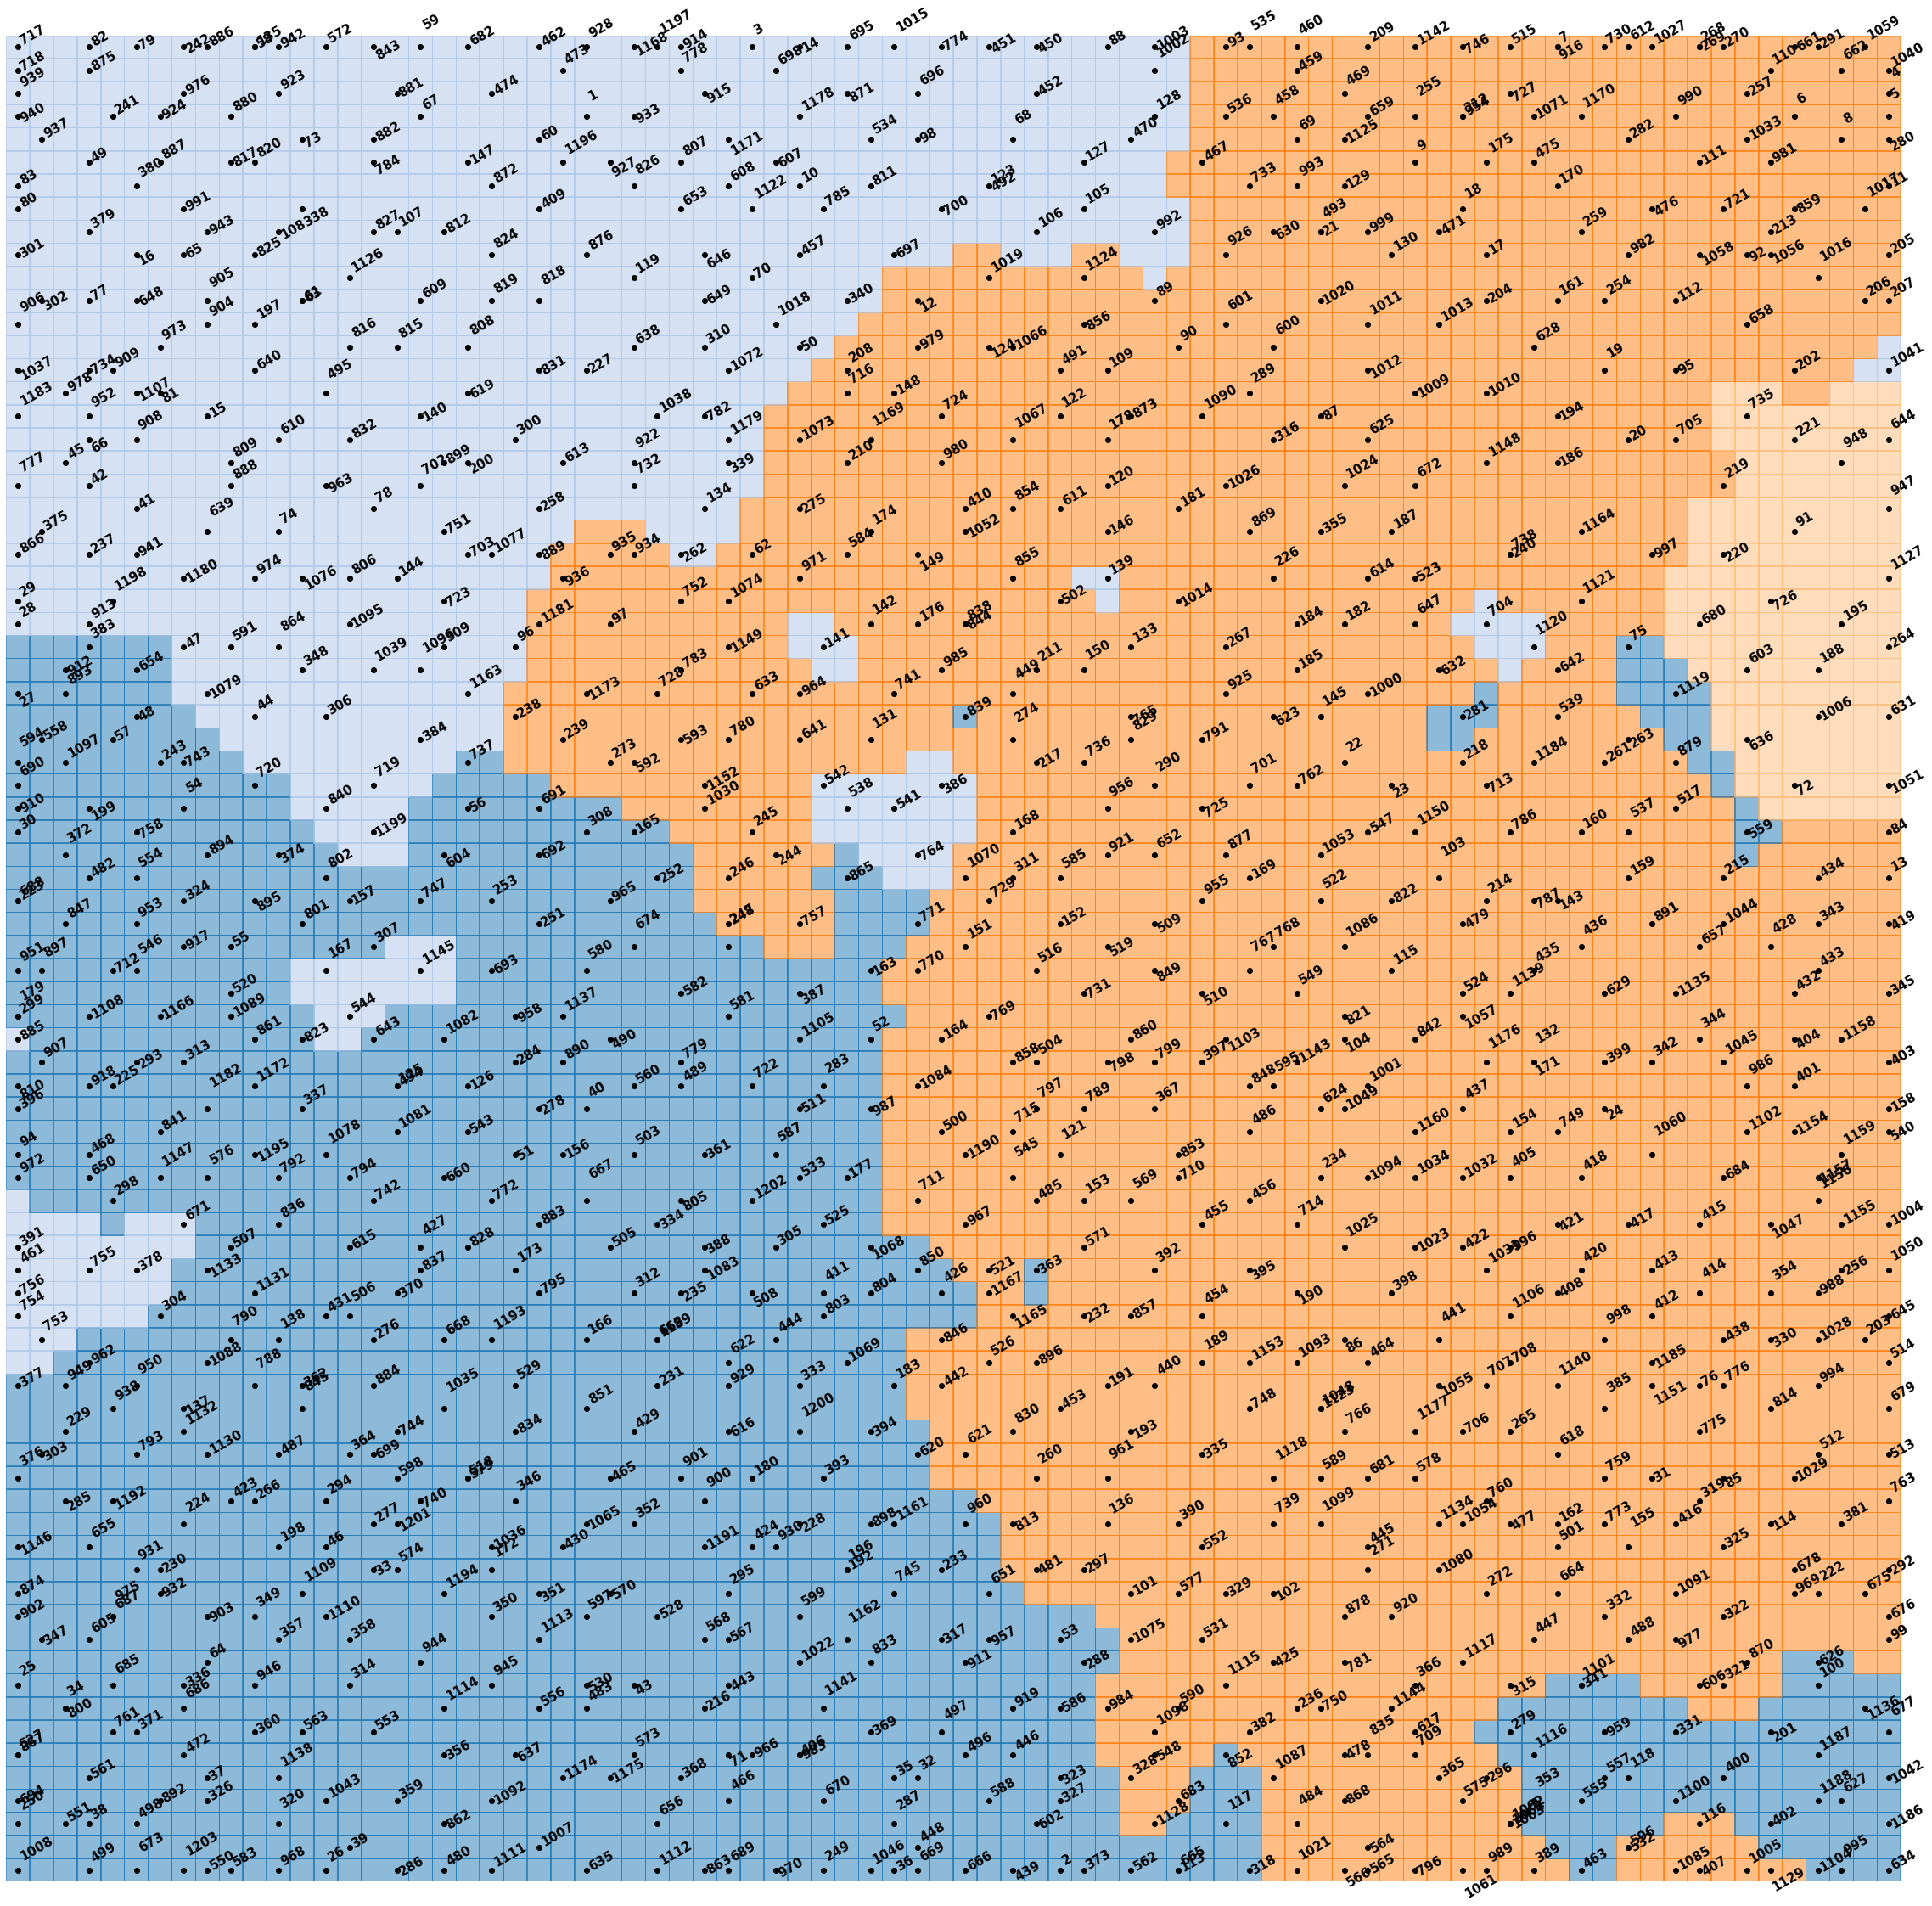

In [39]:
n_clusters = 4

cmap = plt.get_cmap("tab20")
n_palette = 20  # number of different colors in this color palette
color_list = [cmap((i % n_palette)/n_palette) for i in range(n_clusters)]
msz = sm.codebook.mapsize
proj = sm.project_data(sm.data_raw)
coord = sm.bmu_ind_to_xy(proj)

fig, ax = plt.subplots(1, 1, figsize=(40,40))

#cl_labels = som.cluster(n_clusters)
cl_labels = sklearn.cluster.KMeans(n_clusters = n_clusters, 
                                   random_state = 555).fit_predict(sm.codebook.matrix)

# fill each rectangular unit area with cluster color
# and draw line segment to the border of cluster
norm = mpl.colors.Normalize(vmin=0, vmax=n_palette, clip=True)

# borders
ax.pcolormesh(cl_labels.reshape(msz[0], msz[1]).T % n_palette,
            cmap=cmap, norm=norm, edgecolors='face',
            lw=0.5, alpha=0.5)

ax.scatter(coord[:, 0]+0.5, coord[:, 1]+0.5, c='k', marker='o')
ax.axis('off')


for label, x, y in zip(labels, coord[:, 0], coord[:, 1]):
    x += 0.2
    y += 0.2
    # "+ 0.1" means shift of label location to upperright direction

    # randomize the location of the label not to be overwrapped with each other
    # x_text += 0.1 * np.random.randn()
    y += 0.3 * np.random.randn()

    # wrap of label for chemical compound
    # label = str_wrap(label)

    ax.text(x+0.3, y+0.3, label,
            horizontalalignment='left', verticalalignment='bottom',
            rotation=30, fontsize=15, weight='semibold')

#plt.savefig('Images/cluster/Mw_HOMO/cluster_HOMO_Mw.png')

In [40]:
from tfprop_sompy import tfprop_config
from tfprop_sompy import tfprop_vis
from tfprop_sompy import tfprop_analysis

locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x0000021F8C67BE10>
Using auto colorbar locator on colorbar
locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x0000021F8C67BE10>
Setting pcolormesh
locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x0000021F8B962198>
Using auto colorbar locator on colorbar
locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x0000021F8B962198>
Setting pcolormesh
locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x0000021F89598CF8>
Using auto colorbar locator on colorbar
locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x0000021F89598CF8>
Setting pcolormesh
locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x0000021F8447F400>
Using auto colorbar locator on colorbar
locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x0000021F8447F400>
Setting pcolormesh
locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x0000021F84374780>
Using auto colorbar locator on colo

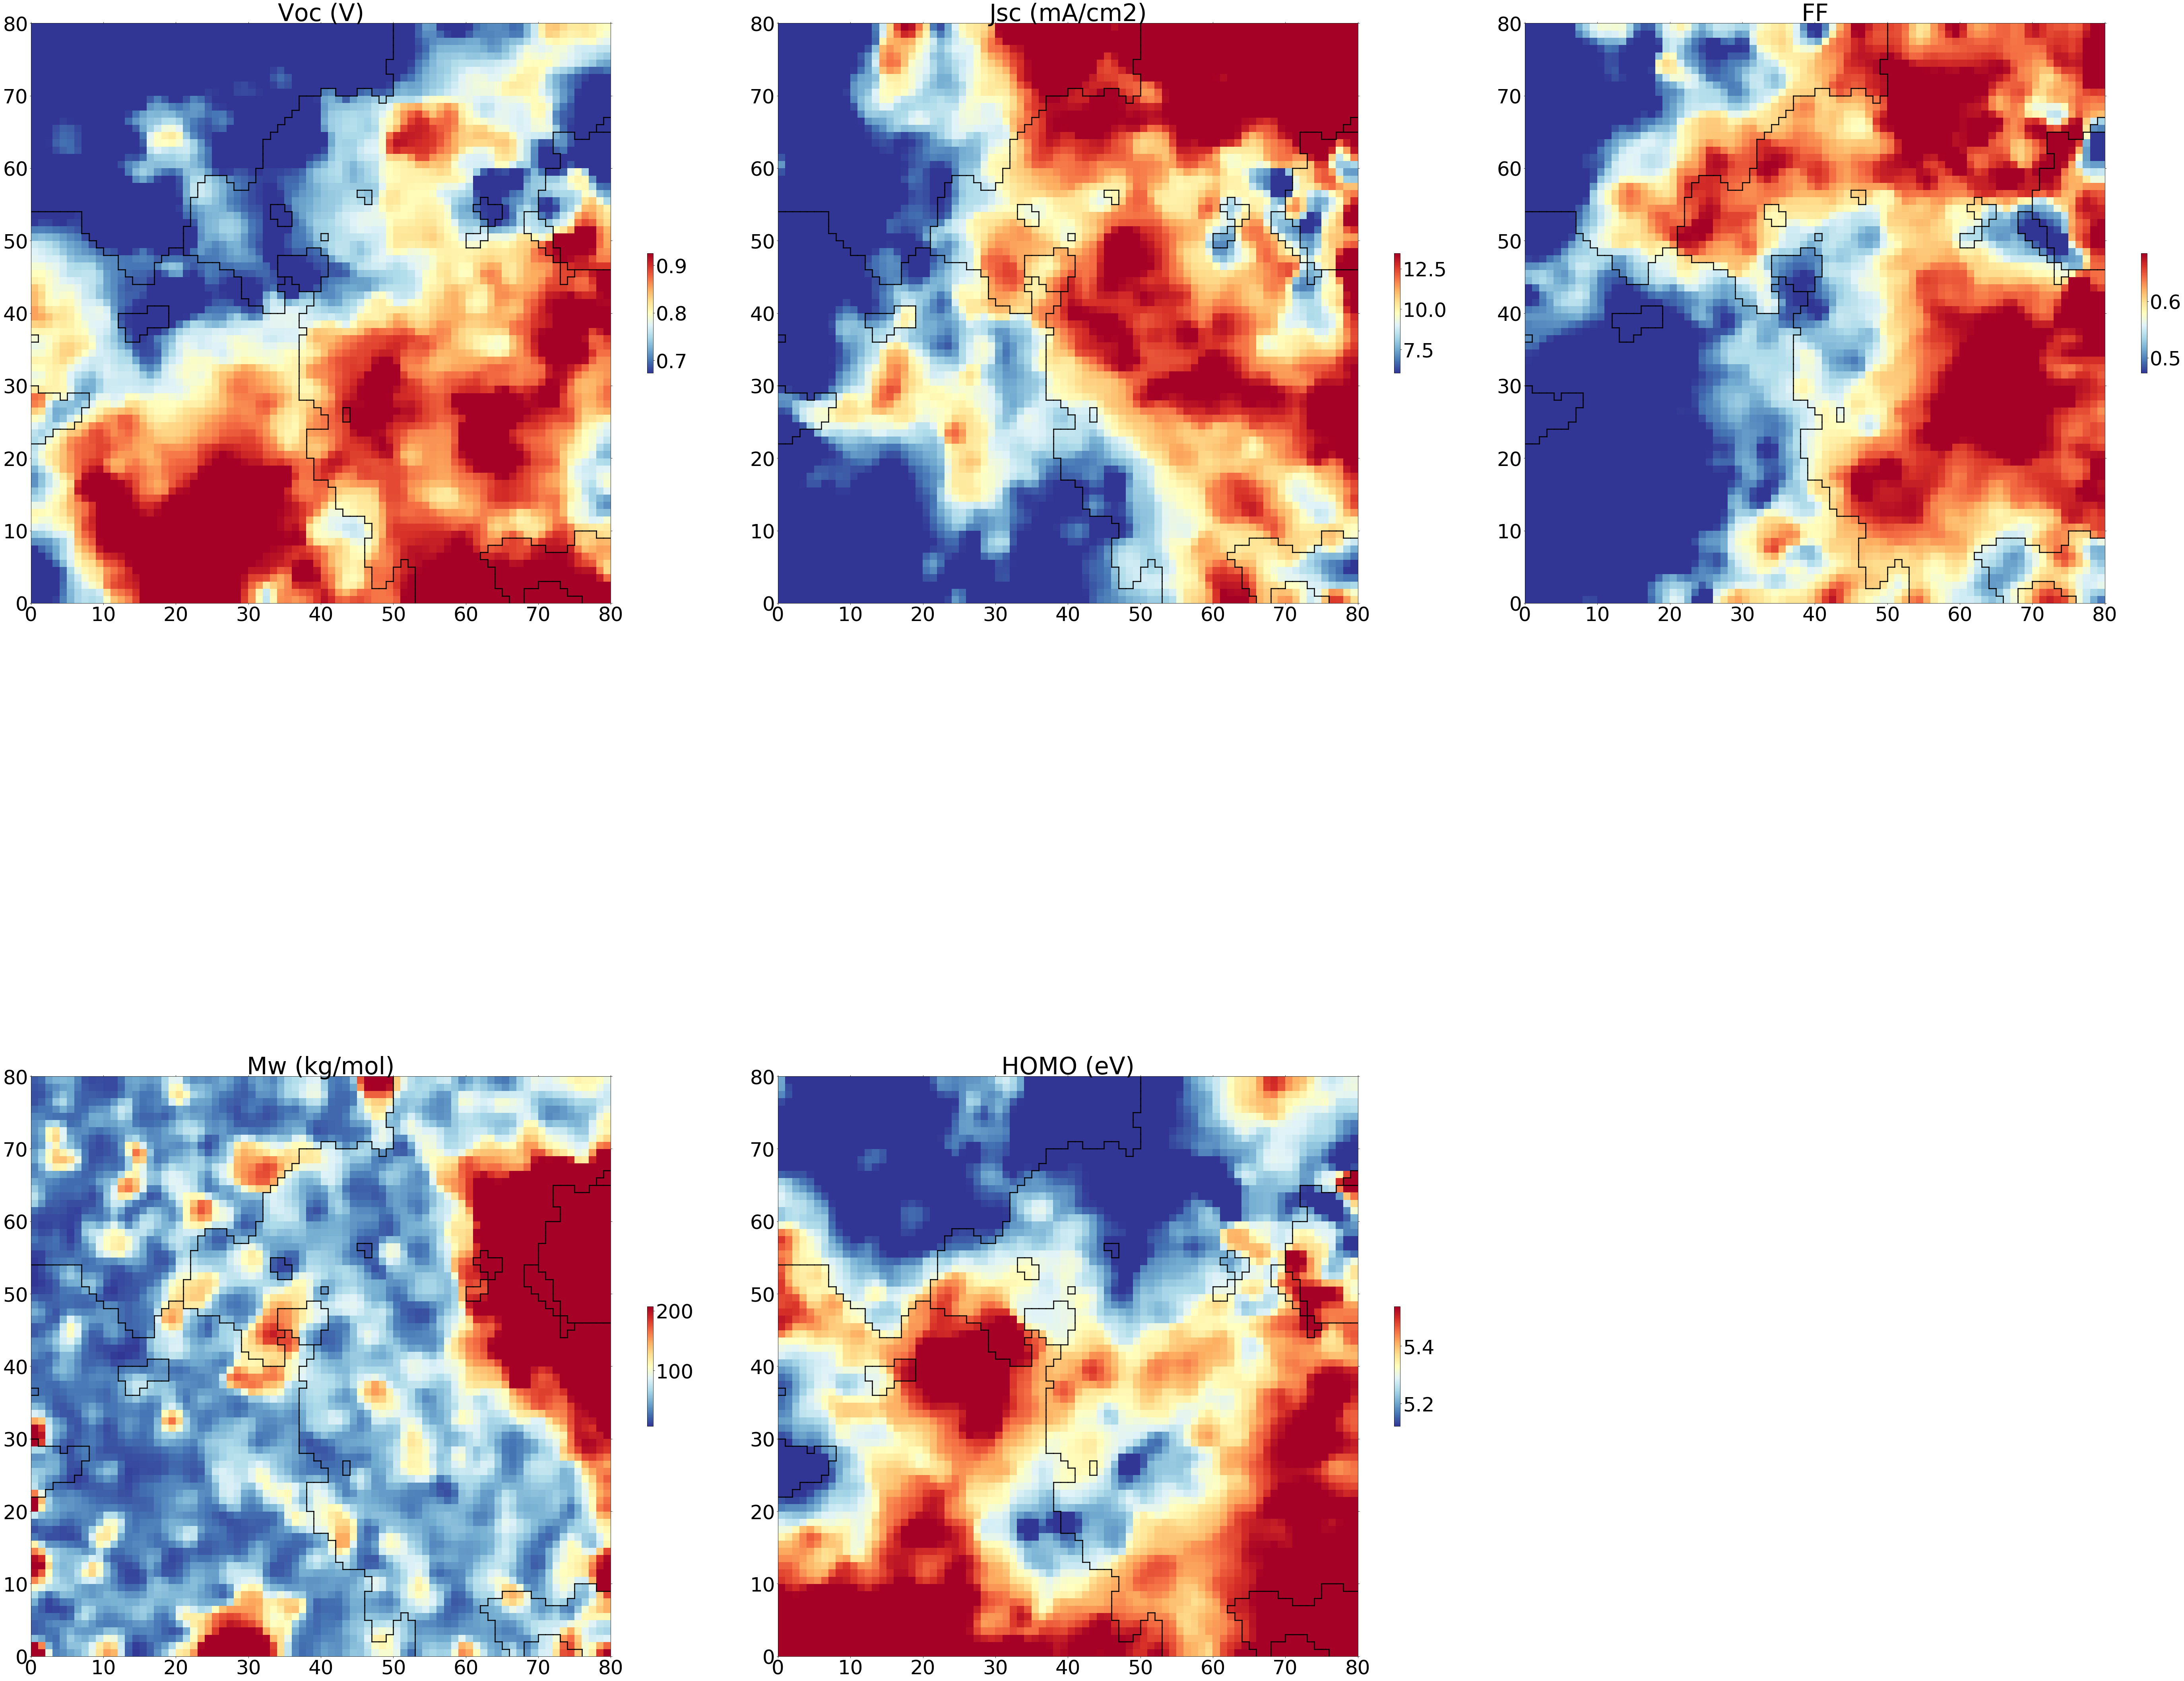

Saving figure of heat map for all thermofluid prop. to Images/component/heatmap_HOMO_Mw.png...


In [41]:
htmap_x, htmap_y = (80, 80)
viewTFP = tfprop_vis.ViewTFP(htmap_x, htmap_y, '',text_size=50)

cmap = plt.get_cmap('RdYlBu_r')  # set color map
comp_map = viewTFP.show(sm, cl_labels, "Images/component/heatmap_HOMO_Mw.png", col_sz=3,
             which_dim='all', desnormalize=True, col_norm='median',cmap=cmap,isOutHtmap=True)

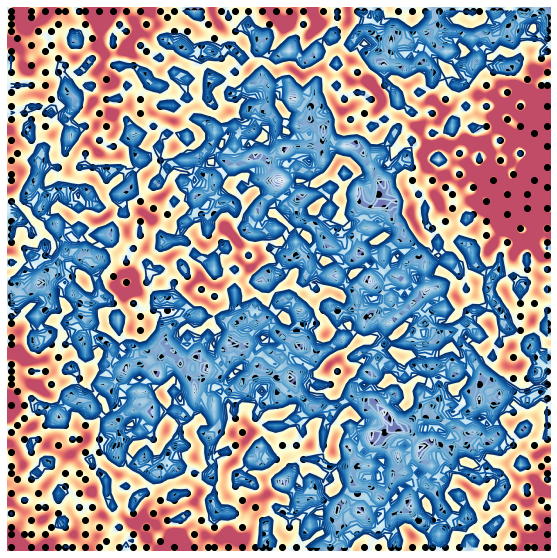

Saving figure of U-matrix to Images/umat/umat_HOMO_Mw.png...


In [42]:
umatrixTFP = tfprop_vis.UMatrixTFP(0, 0, '', text_size=14)

cmap = plt.get_cmap('RdYlBu_r')  # set color map
umat = umatrixTFP.show(sm, pd.DataFrame(labels),
                        pd.DataFrame(labels), "Images/umat/umat_HOMO_Mw.png",
                        show_data=True, labels=False, contooor=True,
                        cmap=cmap,isOutUmat=True,blob = True)

**The right bottom corner was suspected to have sparse data space, thus removing them can be a good option ?**

## Load

In [50]:
def clusteringmap_category(sm,labels,n_clusters,dataset,colorcategory,savepath):

    categories = dataset[colorcategory] #if colorcategory is one col of the dataset
    cmap = plt.get_cmap("tab20") #cmap for background
    n_palette = 20  # number of different colors in this color palette
    color_list = [cmap((i % n_palette)/n_palette) for i in range(n_clusters)]
    msz = sm.codebook.mapsize
    proj = sm.project_data(sm.data_raw)
    coord = sm.bmu_ind_to_xy(proj)

    fig, ax = plt.subplots(1, 1, figsize=(30,30))

    cl_labels = sklearn.cluster.KMeans(n_clusters=n_clusters,random_state=555).fit_predict(sm.codebook.matrix)

    # fill each rectangular unit area with cluster color
    #  and draw line segment to the border of cluster
    norm = mpl.colors.Normalize(vmin=0, vmax=n_palette, clip=True)
#     ax.pcolormesh(cl_labels.reshape(msz[0], msz[1]).T % n_palette,
#                 cmap=cmap, norm=norm, edgecolors='face',
#                 lw=0.5, alpha=0.5)

    ax.scatter(coord[:, 0]+0.5, coord[:, 1]+0.5, c='k', marker='o')
    ax.axis('off')

    categoryname = list(dataset.groupby(colorcategory).count().index)
    categories_int = categories.apply(categoryname.index)

    N = len(categoryname)
    cmap_labels = plt.cm.gist_ncar
    # extract all colors from the .jet map
    cmaplist = [cmap_labels(i) for i in range(cmap_labels.N)]
    # create the new map
    cmap_labels = cmap_labels.from_list('Custom cmap', cmaplist, cmap_labels.N)
    # define the bins and normalize
    bounds = np.linspace(0,N,N+1)
    norm_labels = mpl.colors.BoundaryNorm(bounds, cmap_labels.N)

    scat = ax.scatter(coord[:, 0]+0.5, coord[:, 1]+0.5, c=categories_int,s=300,cmap=cmap_labels,norm=norm_labels)
    cbar = plt.colorbar(scat, spacing='proportional',ticks=bounds)
    cbar.ax.get_yaxis().set_ticks([])
    
    for j, lab in enumerate(categoryname):
        cbar.ax.text(1, (2 * j + 1) / (2*(len(categoryname))), lab, ha='left', va='center', fontsize=30)
    cbar.ax.get_yaxis().labelpad = 15
    #cbar.ax.set_ylabel('# of contacts', rotation=270)
    ax.axis('off')

    for label, x, y in zip(labels, coord[:, 0], coord[:, 1]):
        x += 0.2
        y += 0.2
        # "+ 0.1" means shift of label location to upperright direction

        # randomize the location of the label
        #   not to be overwrapped with each other
        # x_text += 0.1 * np.random.randn()
        y += 0.3 * np.random.randn()

        # wrap of label for chemical compound
        #label = str_wrap(label)

        ax.text(x+0.3, y+0.3, label,
                horizontalalignment='left', verticalalignment='bottom',
                rotation=30, fontsize=12, weight='semibold')
            #cl_labels = som.cluster(n_clusters)
    cl_labels = sklearn.cluster.KMeans(n_clusters = n_clusters, 
                                       random_state = 555).fit_predict(sm.codebook.matrix)

    for i in range(len(cl_labels)):
        rect_x = [i // msz[1], i // msz[1],
                i // msz[1] + 1, i // msz[1] + 1]
        rect_y = [i % msz[1], i % msz[1] + 1,
                i % msz[1] + 1, i % msz[1]]

        if i % msz[1] + 1 < msz[1]:  # top border
            if cl_labels[i] != cl_labels[i+1]:
                ax.plot([rect_x[1], rect_x[2]],
                        [rect_y[1], rect_y[2]], 'k-', lw=2.5)

        if i + msz[1] < len(cl_labels):  # right border
            if cl_labels[i] != cl_labels[i+msz[1]]:
                ax.plot([rect_x[2], rect_x[3]],
                        [rect_y[2], rect_y[3]], 'k-', lw=2.5)
    
    plt.savefig(savepath)
    return cl_labels

In [15]:
PDI = pd.read_csv("./data/PDI.csv")
IDT = pd.read_csv("./data/IDT.csv")
BDT = pd.read_csv("./data/BDT.csv")
NTz = pd.read_csv("./data/NTz.csv")
DPP = pd.read_csv("./data/DPP.csv")

In [31]:
PDI['Zagreb1_Categ'] = classify_by_group(PDI,"Zagreb1",5)
IDT['Zagreb1_Categ'] = classify_by_group(IDT,"Zagreb1",5)
BDT['Zagreb1_Categ'] = classify_by_group(BDT,"Zagreb1",5)
NTz['Zagreb1_Categ'] = classify_by_group(NTz,"Zagreb1",5)
DPP['Zagreb1_Categ'] = classify_by_group(DPP,"Zagreb1",5)

data['Zagreb1_Categ'] = classify_by_group(data,"Zagreb1",5)

locator: <matplotlib.ticker.FixedLocator object at 0x0000021F87228A20>
Using fixed locator on colorbar
Setting pcolormesh
locator: <matplotlib.ticker.FixedLocator object at 0x0000021F87C23BA8>
Using fixed locator on colorbar
Setting pcolormesh
locator: <matplotlib.ticker.FixedLocator object at 0x0000021F88A22B70>
Using fixed locator on colorbar
Setting pcolormesh
locator: <matplotlib.ticker.FixedLocator object at 0x0000021F89591B70>
Using fixed locator on colorbar
Setting pcolormesh


array([0, 0, 0, ..., 2, 2, 2])

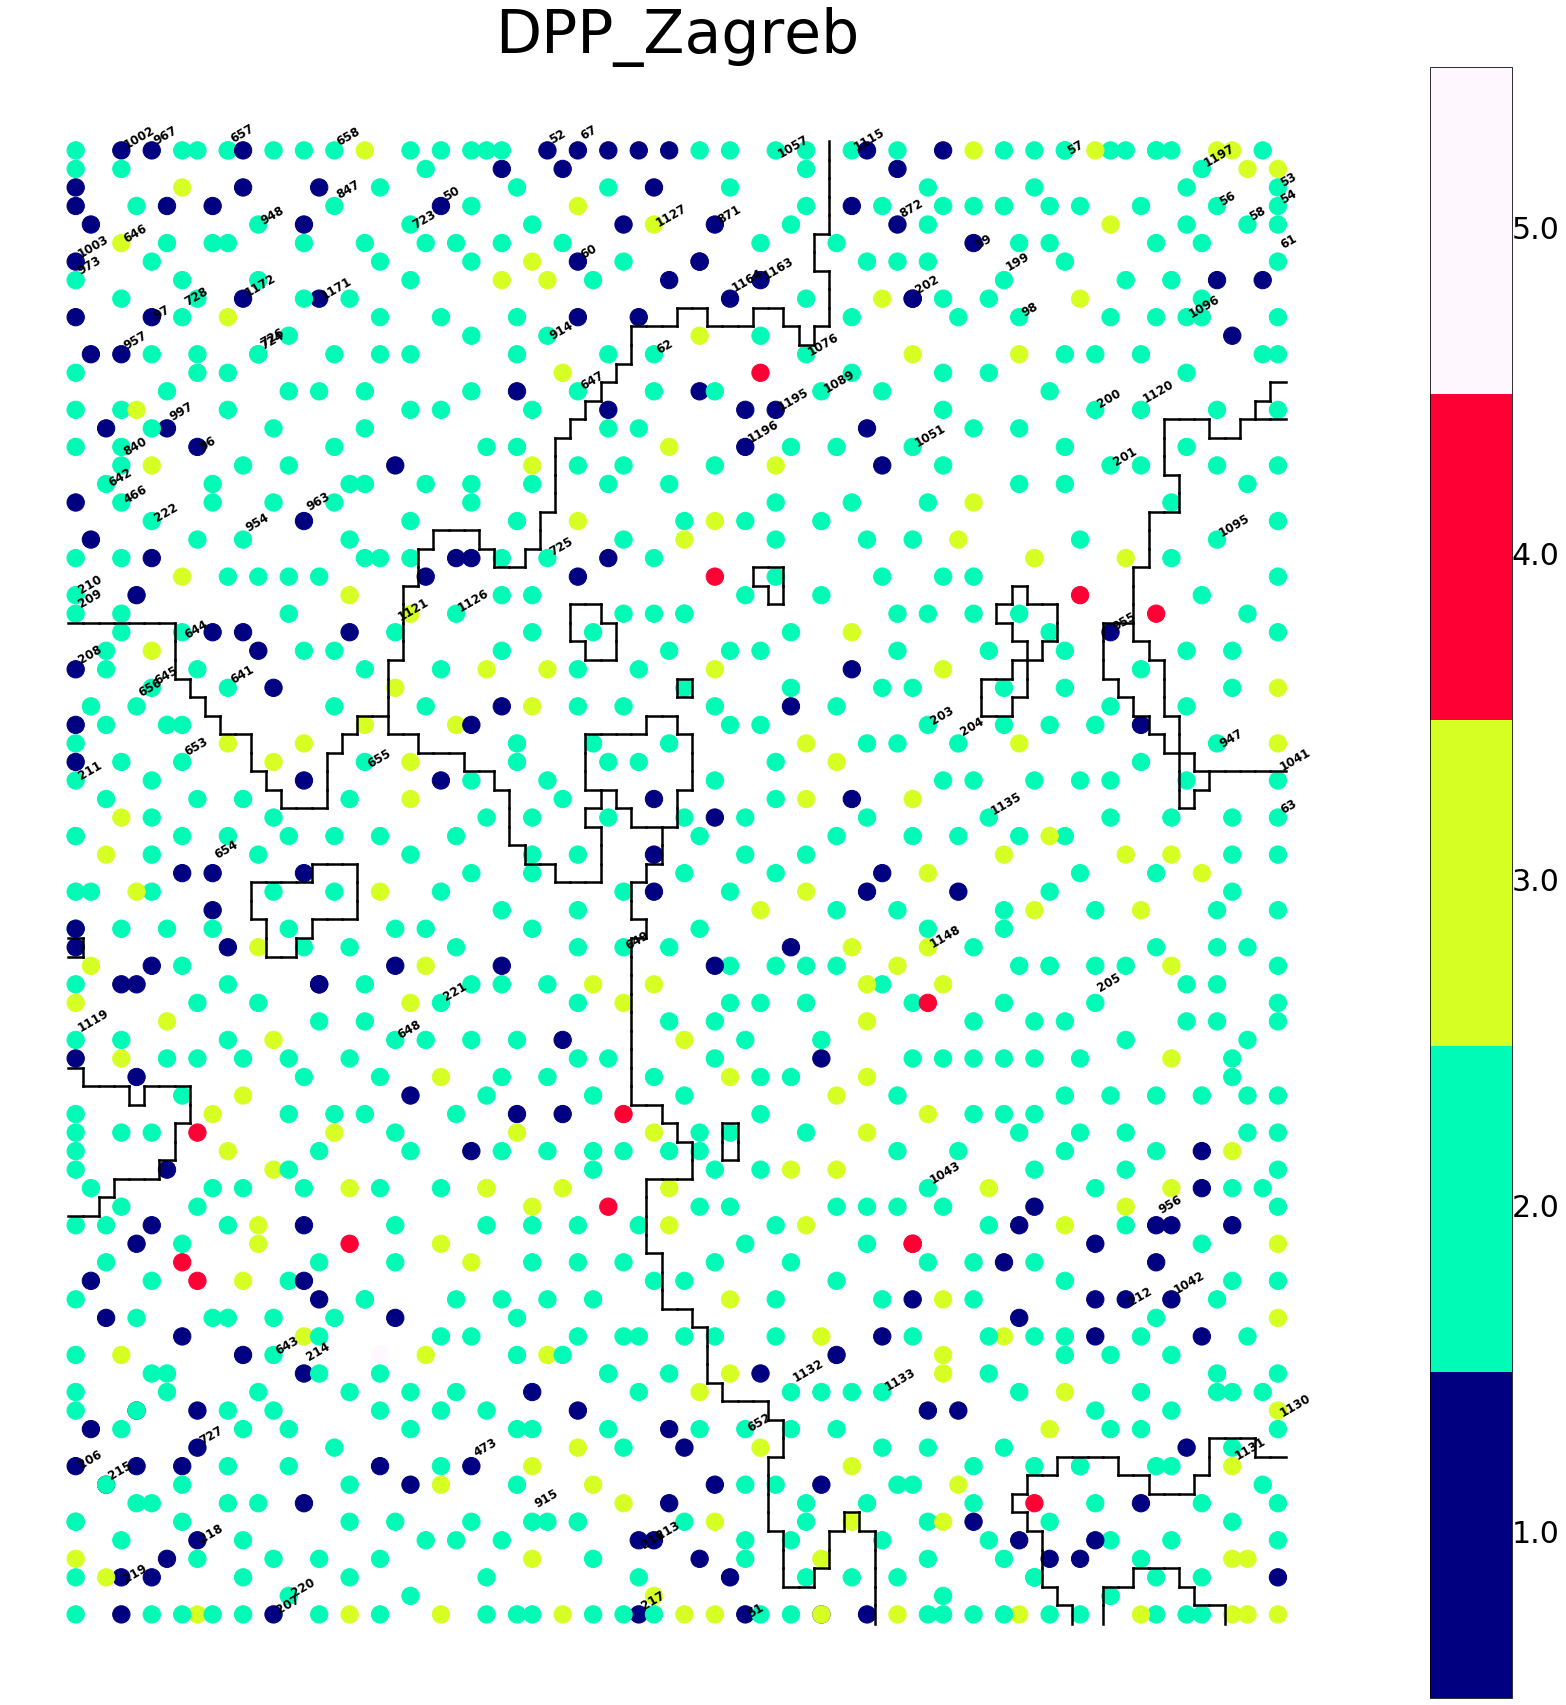

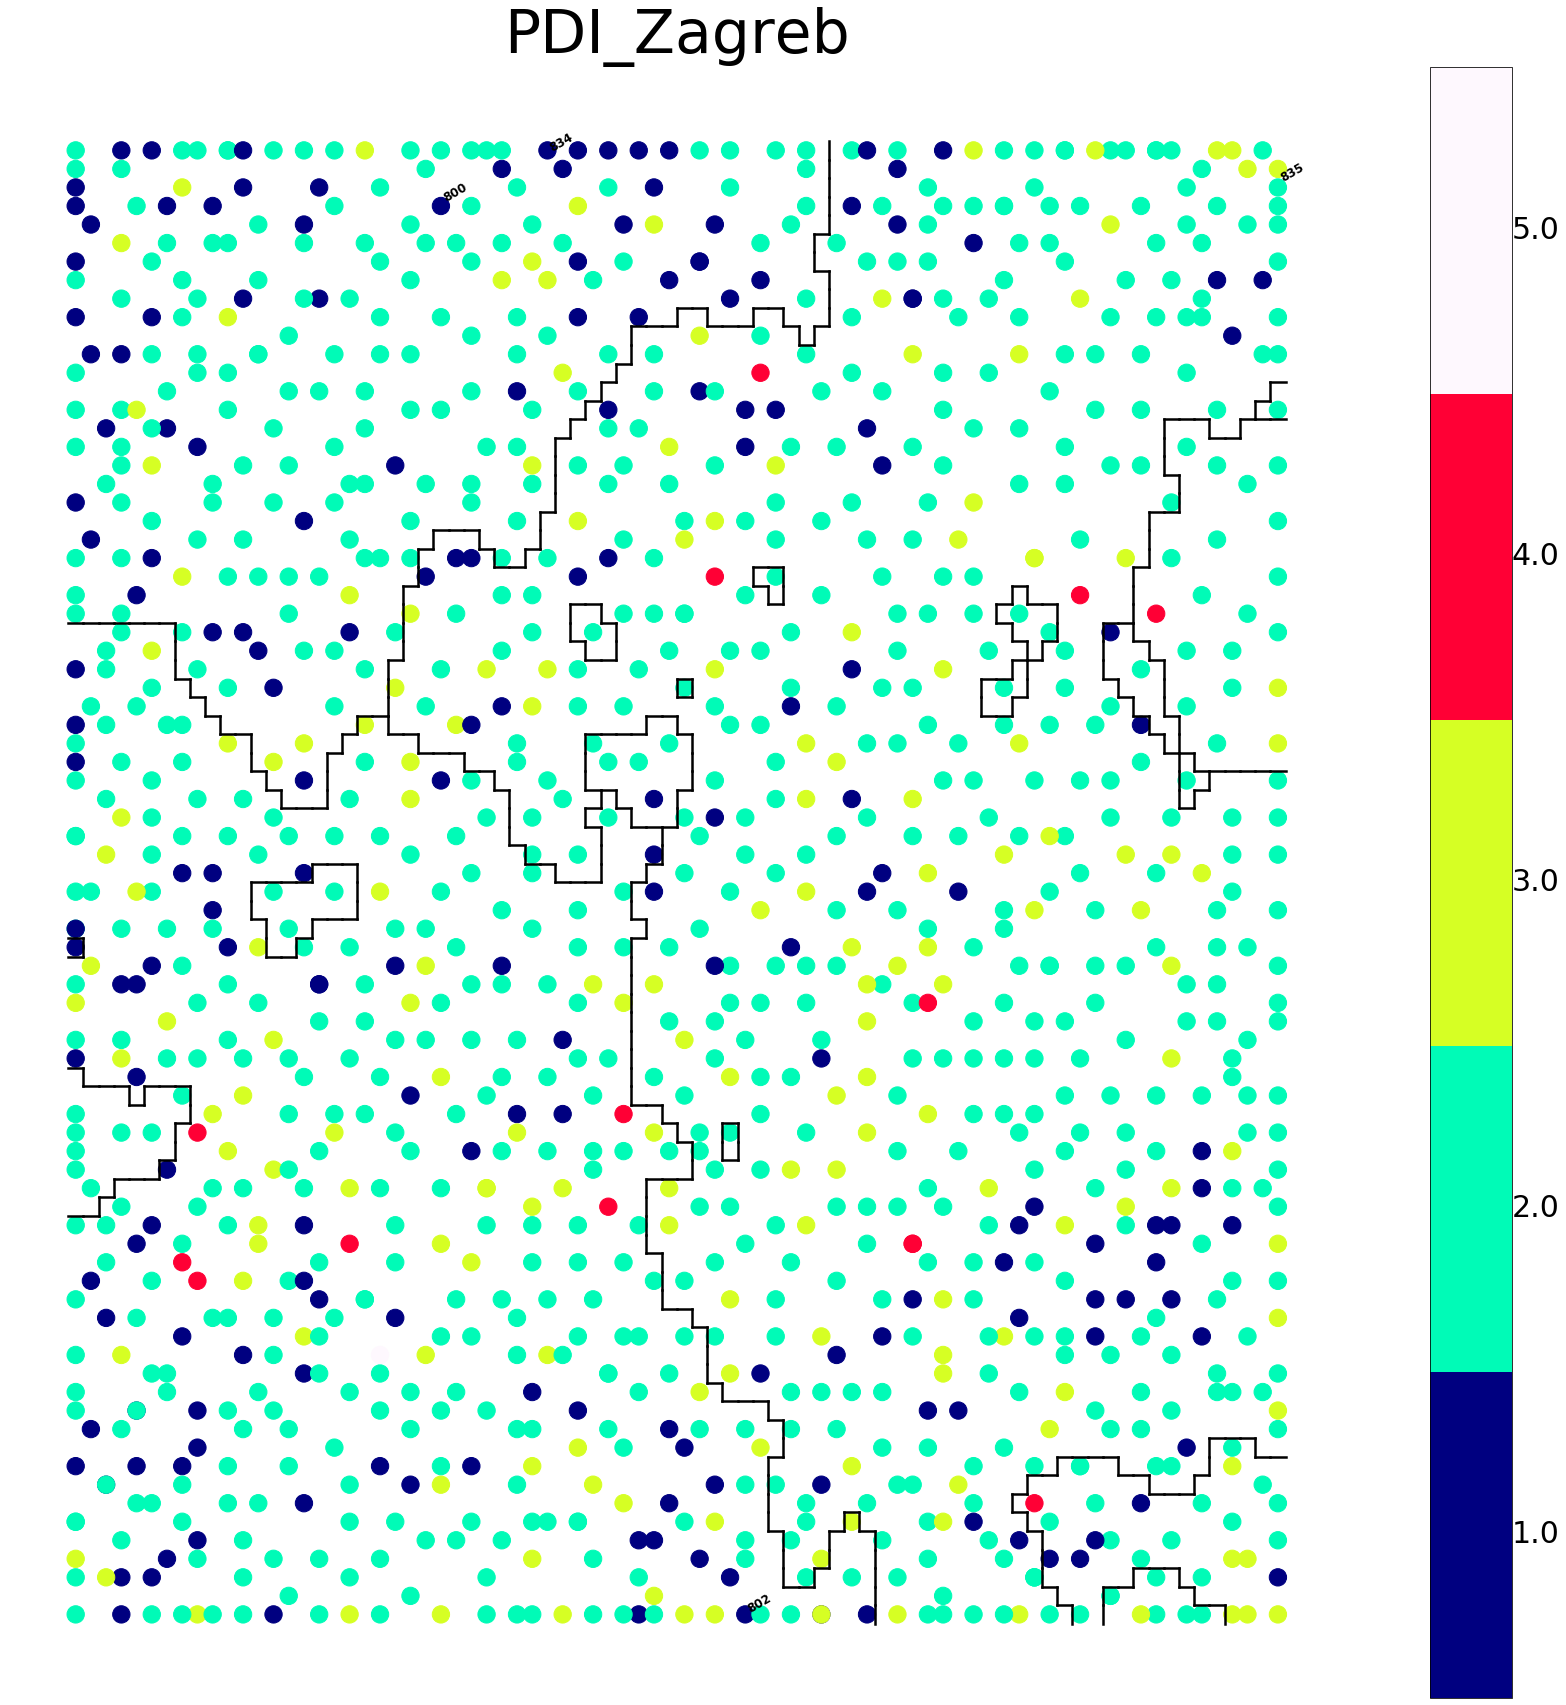

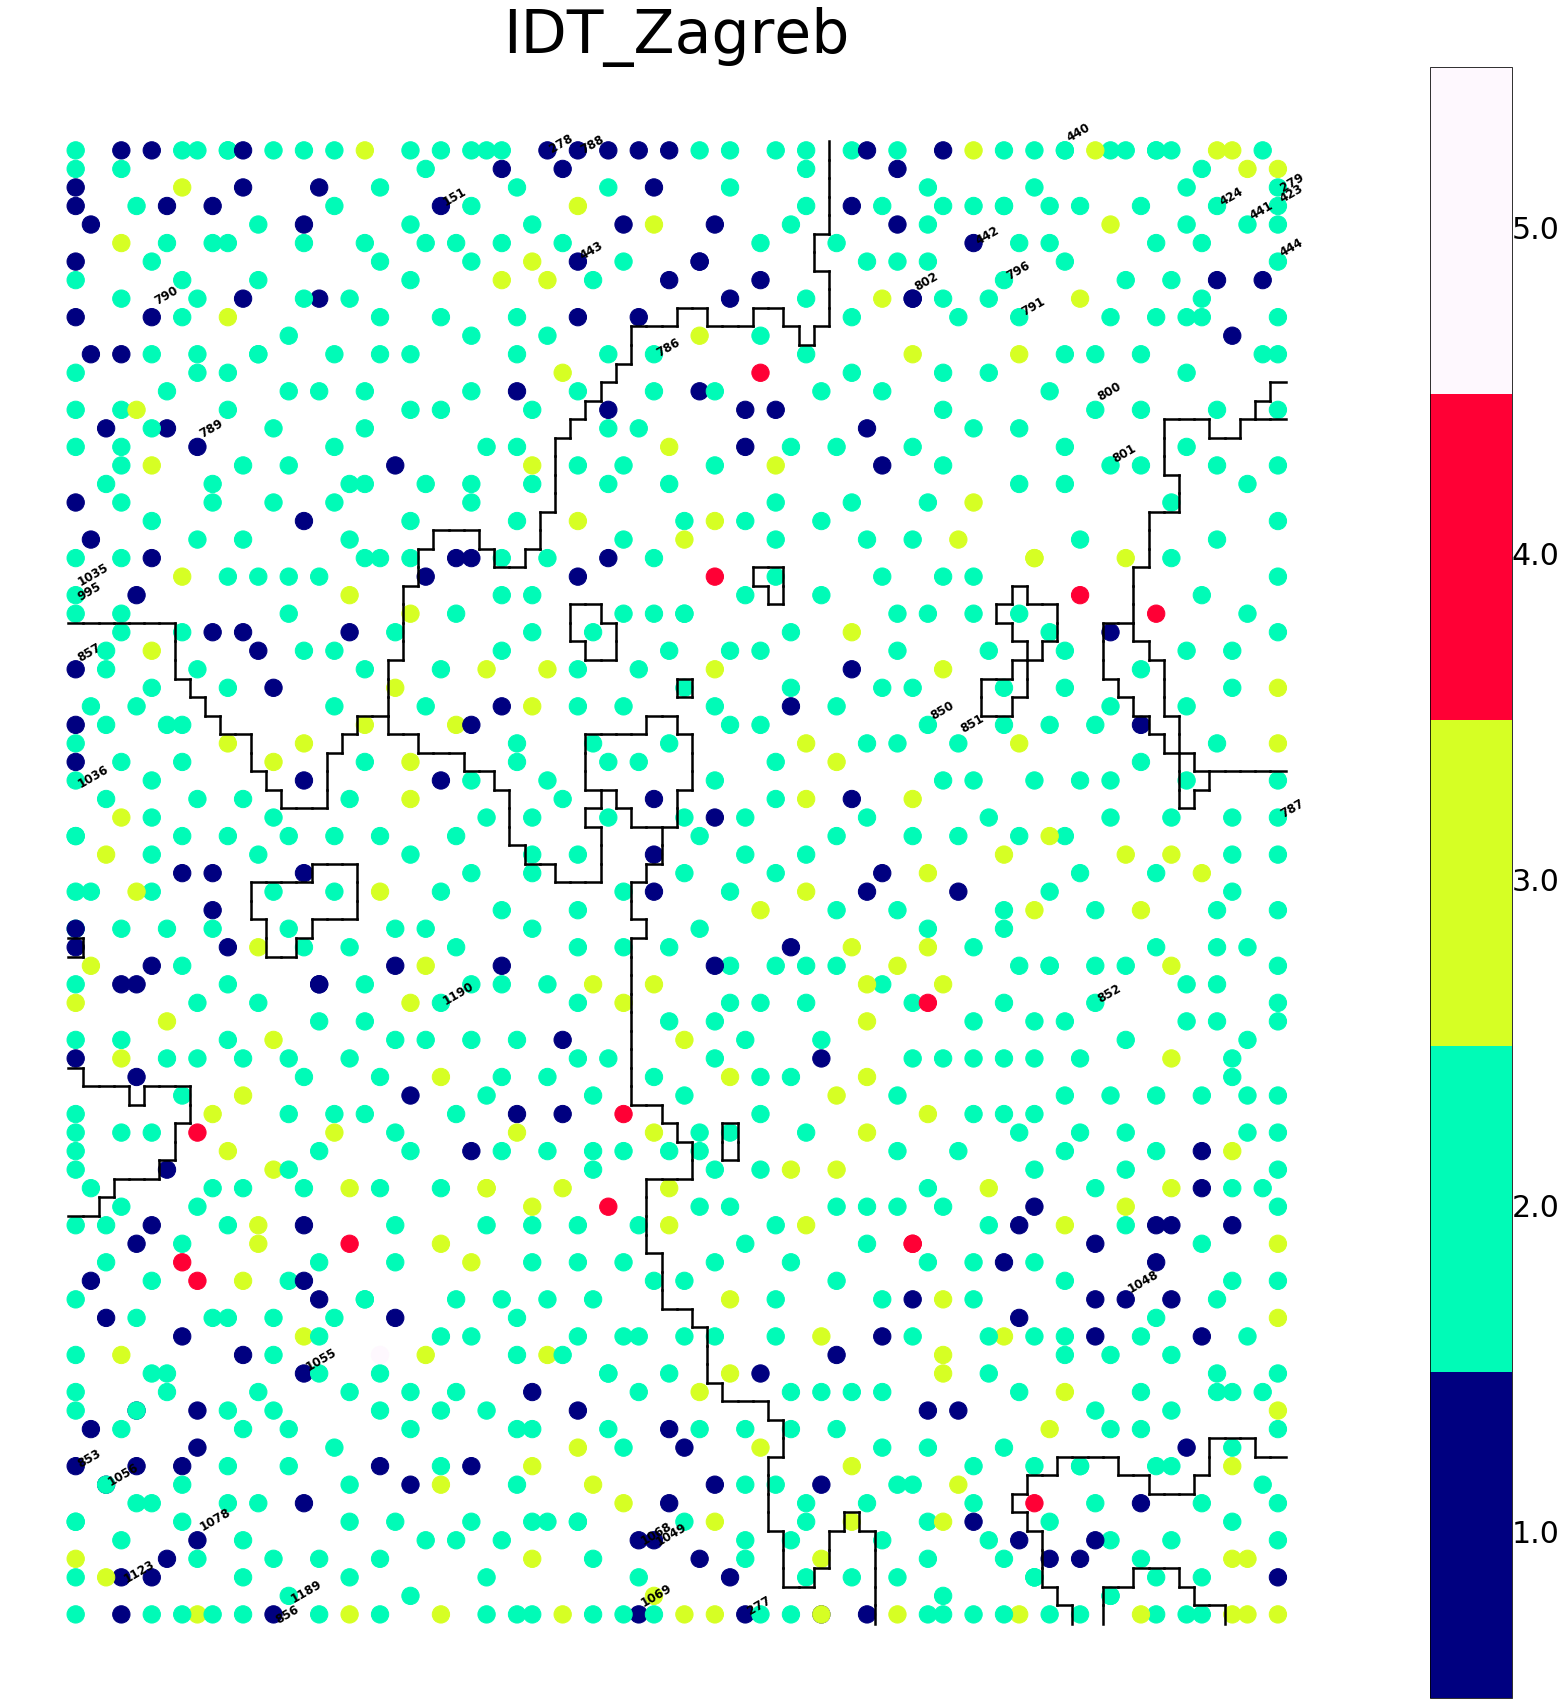

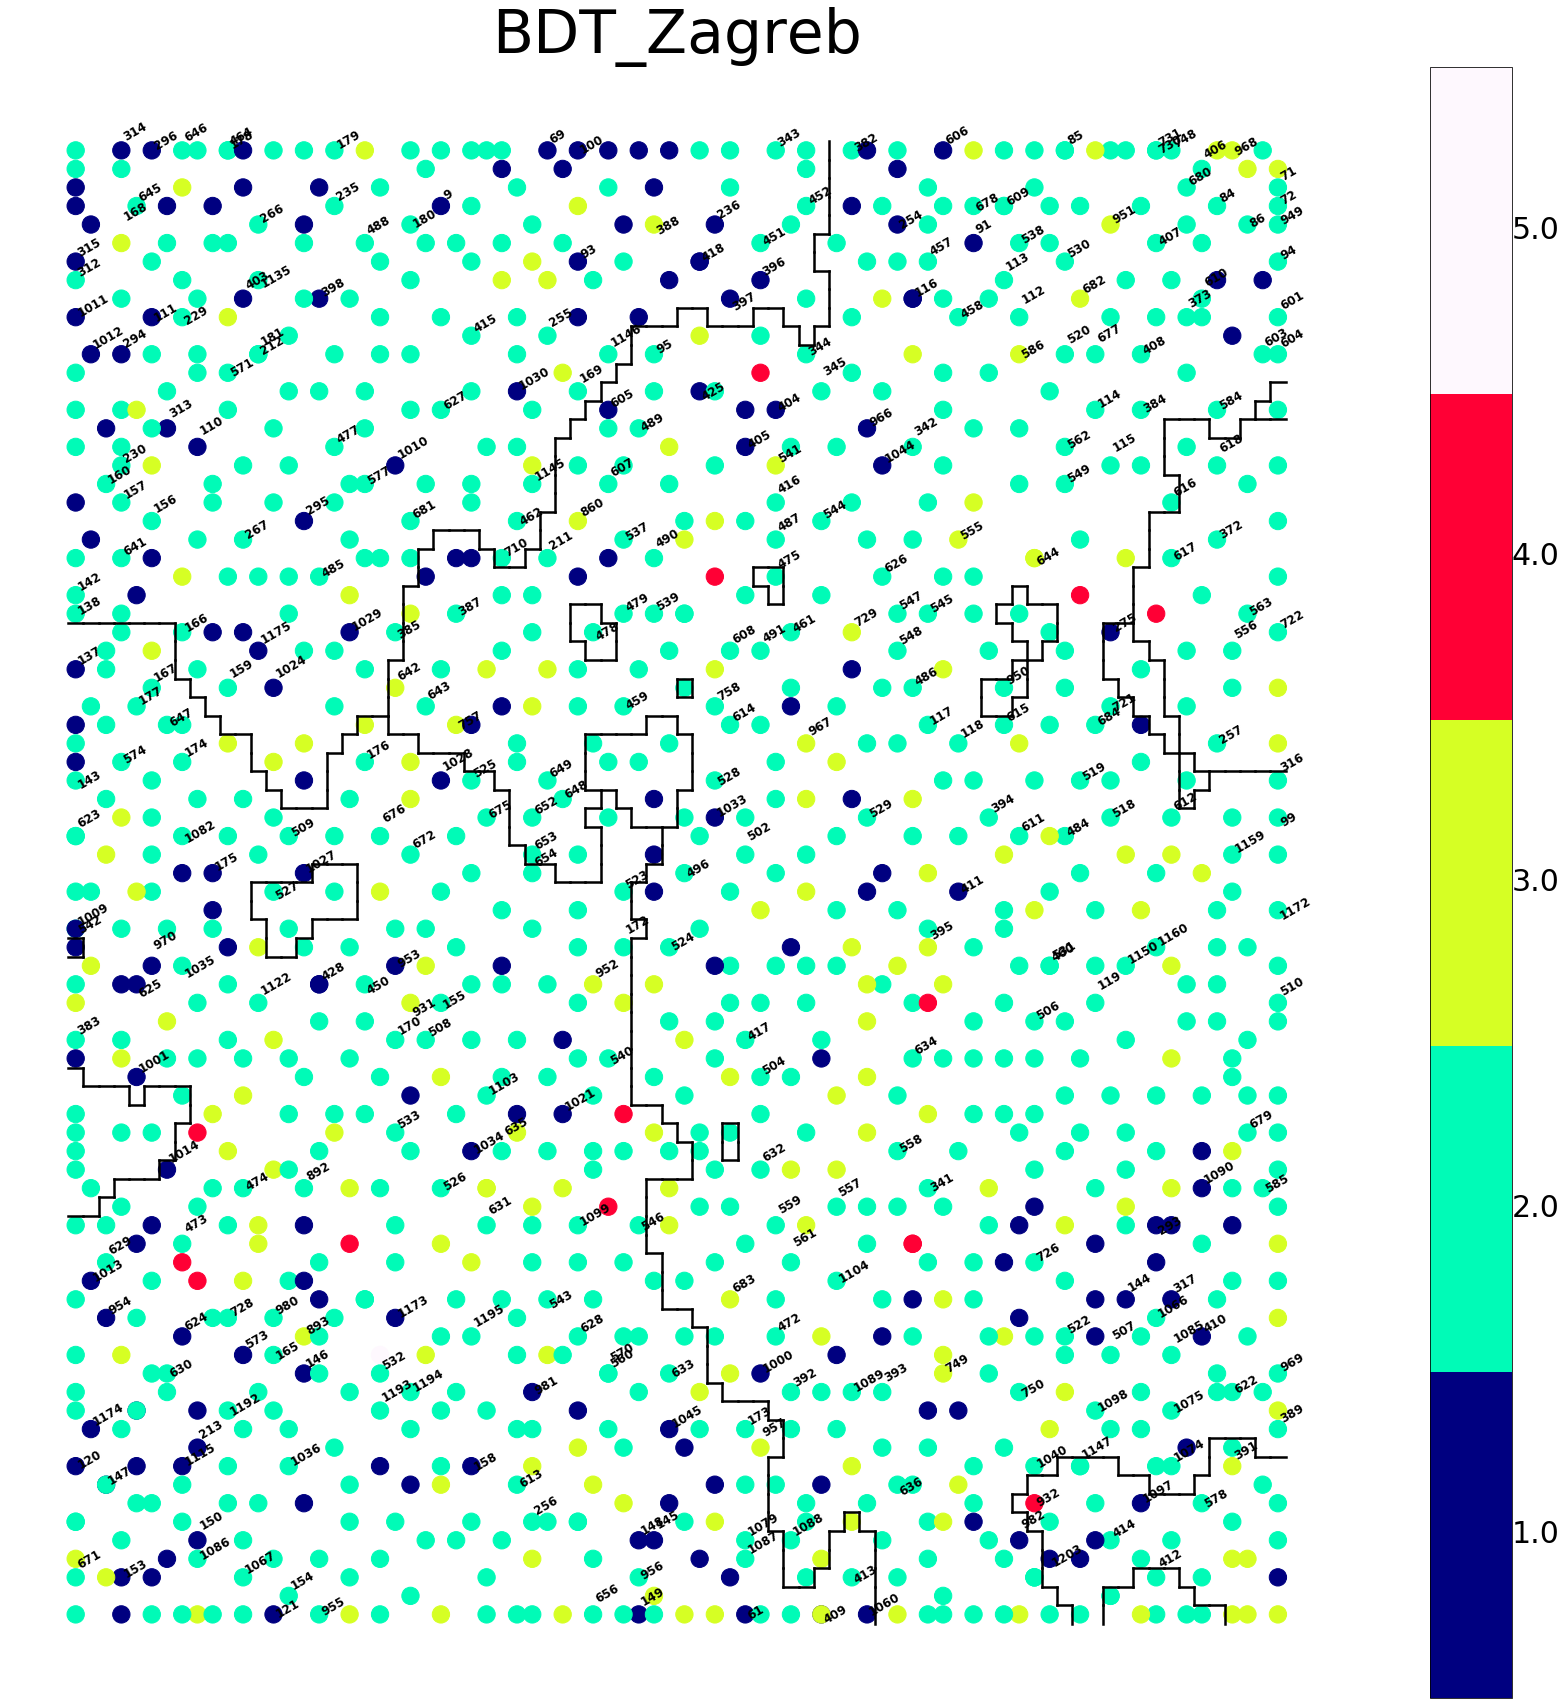

In [32]:
clusteringmap_category(sm,list(DPP['ID No.']),4,data,"Zagreb1_Categ",'DPP_Zagreb','./Images/descriptors/Mw_HOMO/DPP_Zagreb.png')
clusteringmap_category(sm,list(PDI['ID No.']),4,data,"Zagreb1_Categ",'PDI_Zagreb','./Images/descriptors/Mw_HOMO/PDI_Zagreb.png')
clusteringmap_category(sm,list(IDT['ID No.']),4,data,"Zagreb1_Categ",'IDT_Zagreb','./Images/descriptors/Mw_HOMO/IDT_Zagreb.png')
clusteringmap_category(sm,list(BDT['ID No.']),4,data,"Zagreb1_Categ",'BDT_Zagreb','./Images/descriptors/Mw_HOMO/BDT_Zagreb.png')

In [46]:
data["PCE_Categ"] = classify_by_group(data,"PCE_ave",5)

In [47]:
def sort_by_value(target, categ, data):
    """
    
    """
    result = []
    ind = 0
    for value in categ:
        if target == value:
            result.append(data.iloc[ind])
        ind += 1
    return pd.DataFrame(result)

In [51]:
high_PCE_5 = sort_by_value(5, data['PCE_Categ'], data)
high_ind = list(high_PCE_5.Nickname)
high_PCE_5

Nickname Ref. No  PCE_max  PCE_ave  Voc (V)  Jsc (mA/cm2)    FF  \
4          PffBT4T-2OD      S4    10.50    10.20     0.77         18.40  0.74   
5          PffBT4T-2OD      S4    10.40    10.00     0.77         18.20  0.74   
6          PffBT4T-2OD      S4     9.00     9.00     0.76         17.90  0.65   
8           PNTz4T-2OD      S4    10.10     9.70     0.76         19.80  0.68   
11              PNTz4T      S7    10.10     9.77     0.71         19.40  0.73   
13              PNOz4T      S9     8.90     8.50     0.96         14.50  0.64   
84             PBDT-BT     S38     9.40     9.15     0.92         15.40  0.64   
87               PBQ-4     S41     8.55     8.55     0.90         13.58  0.70   
110           PBDT-TS1     S49     9.52     9.52     0.81         17.55  0.67   
205          C3-DPPTTT     S88     8.80     8.80     0.57         23.50  0.66   
257           PBDT-TS1    S102     9.48     9.19     0.80         17.37  0.66   
264           PNTz4TF2    S106    10.50    10.10     0.82         19.30  0.67   
268        PTzNTz-EHBO    S108     9.00     8.70     0.84         16.00  0.67   
269        PTzNTz-EHHD    S108     8.80     8.50     0.84         15.60  0.67   
270        PTzNTz-BOBO    S108     8.80     8.50     0.84         16.60  0.63   
280              NT812    S112    10.33    10.18     0.72         19.09  0.73   
291            rr-PTBS    S117    10.31    10.19     0.82         19.63  0.63   
345            PThBDTP    S140     9.13     8.98     0.96         12.59  0.76   
354             PITFBT    S143     9.14     9.14     0.90         15.36  0.66   
405           PTZBIBDT    S165     8.63     8.63     0.87         13.50  0.74   
408      PBDTBDD (PM6)    S167     9.20     9.20     0.98         12.70  0.74   
415        POBDT(S)-T1    S170     9.20     9.20     0.98         12.90  0.72   
417           PBDT-ST1    S171     9.00     9.00     0.91         13.70  0.75   
419            PDBT-T1    S172     9.74     9.74     0.92         14.11  0.75   
420            PBT1-MP    S173     8.70     8.70     0.98         12.90  0.73   
421            PBT1-EH    S173    10.30    10.30     0.97         14.21  0.75   
600            PBDF-T1    S240     9.23     8.87     0.91         13.49  0.76   
661   PffBT-T3((1,2)-1    S264    10.00     9.70     0.82         18.50  0.64   
662    PffBT-T3(1,2)-2    S264    10.70    10.50     0.82         18.70  0.68   
735            TBTIT-h    S291     9.10     9.10     0.72         17.70  0.71   
981         PBDTTT-EFT    S400     9.00     9.00     0.78         16.86  0.68   
982         PBDTTT-EFS    S400     8.78     8.78     0.81         16.57  0.66   
996          PBDD-ff4T    S407     9.20     8.80     0.95         13.20  0.73   
999            PTB7-TV    S410     8.55     8.55     0.75         15.75  0.72   
1004       PffBX4T-2OD    S413     9.40     9.10     0.88         15.80  0.66   
1011      PBDTDTffBT-H    S415     9.44     9.34     0.88         14.92  0.72   
1012      PBDTDTffBT-R    S415     9.09     9.01     0.88         13.98  0.74   
1013          PBDTTT-H    S415     9.38     9.21     0.80         17.37  0.68   
1017                P3    S416     9.76     9.61     0.66         20.69  0.71   
1023             PMOT5    S419     9.25     9.11     0.96         13.45  0.71   
1027     PBDTBO-CIBTDD    S420     9.11     9.01     0.76         16.79  0.72   
1032           PBPD-Se    S421     9.80     9.60     0.90         14.90  0.73   
1033     PBDTT-O-TT-CF    S422     8.68     8.68     0.78         16.50  0.68   
1034     PBDTT-S-TT-CF    S422     9.58     9.58     0.89         15.10  0.71   
1040          PBDT-TSR    S426    10.20     9.91     0.80         17.79  0.71   
1047                P2    S429     9.26     9.13     0.87         14.91  0.71   
1050           PBTF-OP    S431     9.00     8.90     0.86         16.40  0.62   
1051             PCDPP    S432     9.02     9.02     0.86         16.00  0.65   
1059              P-TT    S437     9.96     9

locator: <matplotlib.ticker.FixedLocator object at 0x0000021F84059A90>
Using fixed locator on colorbar
Setting pcolormesh


array([0, 0, 0, ..., 2, 2, 2])

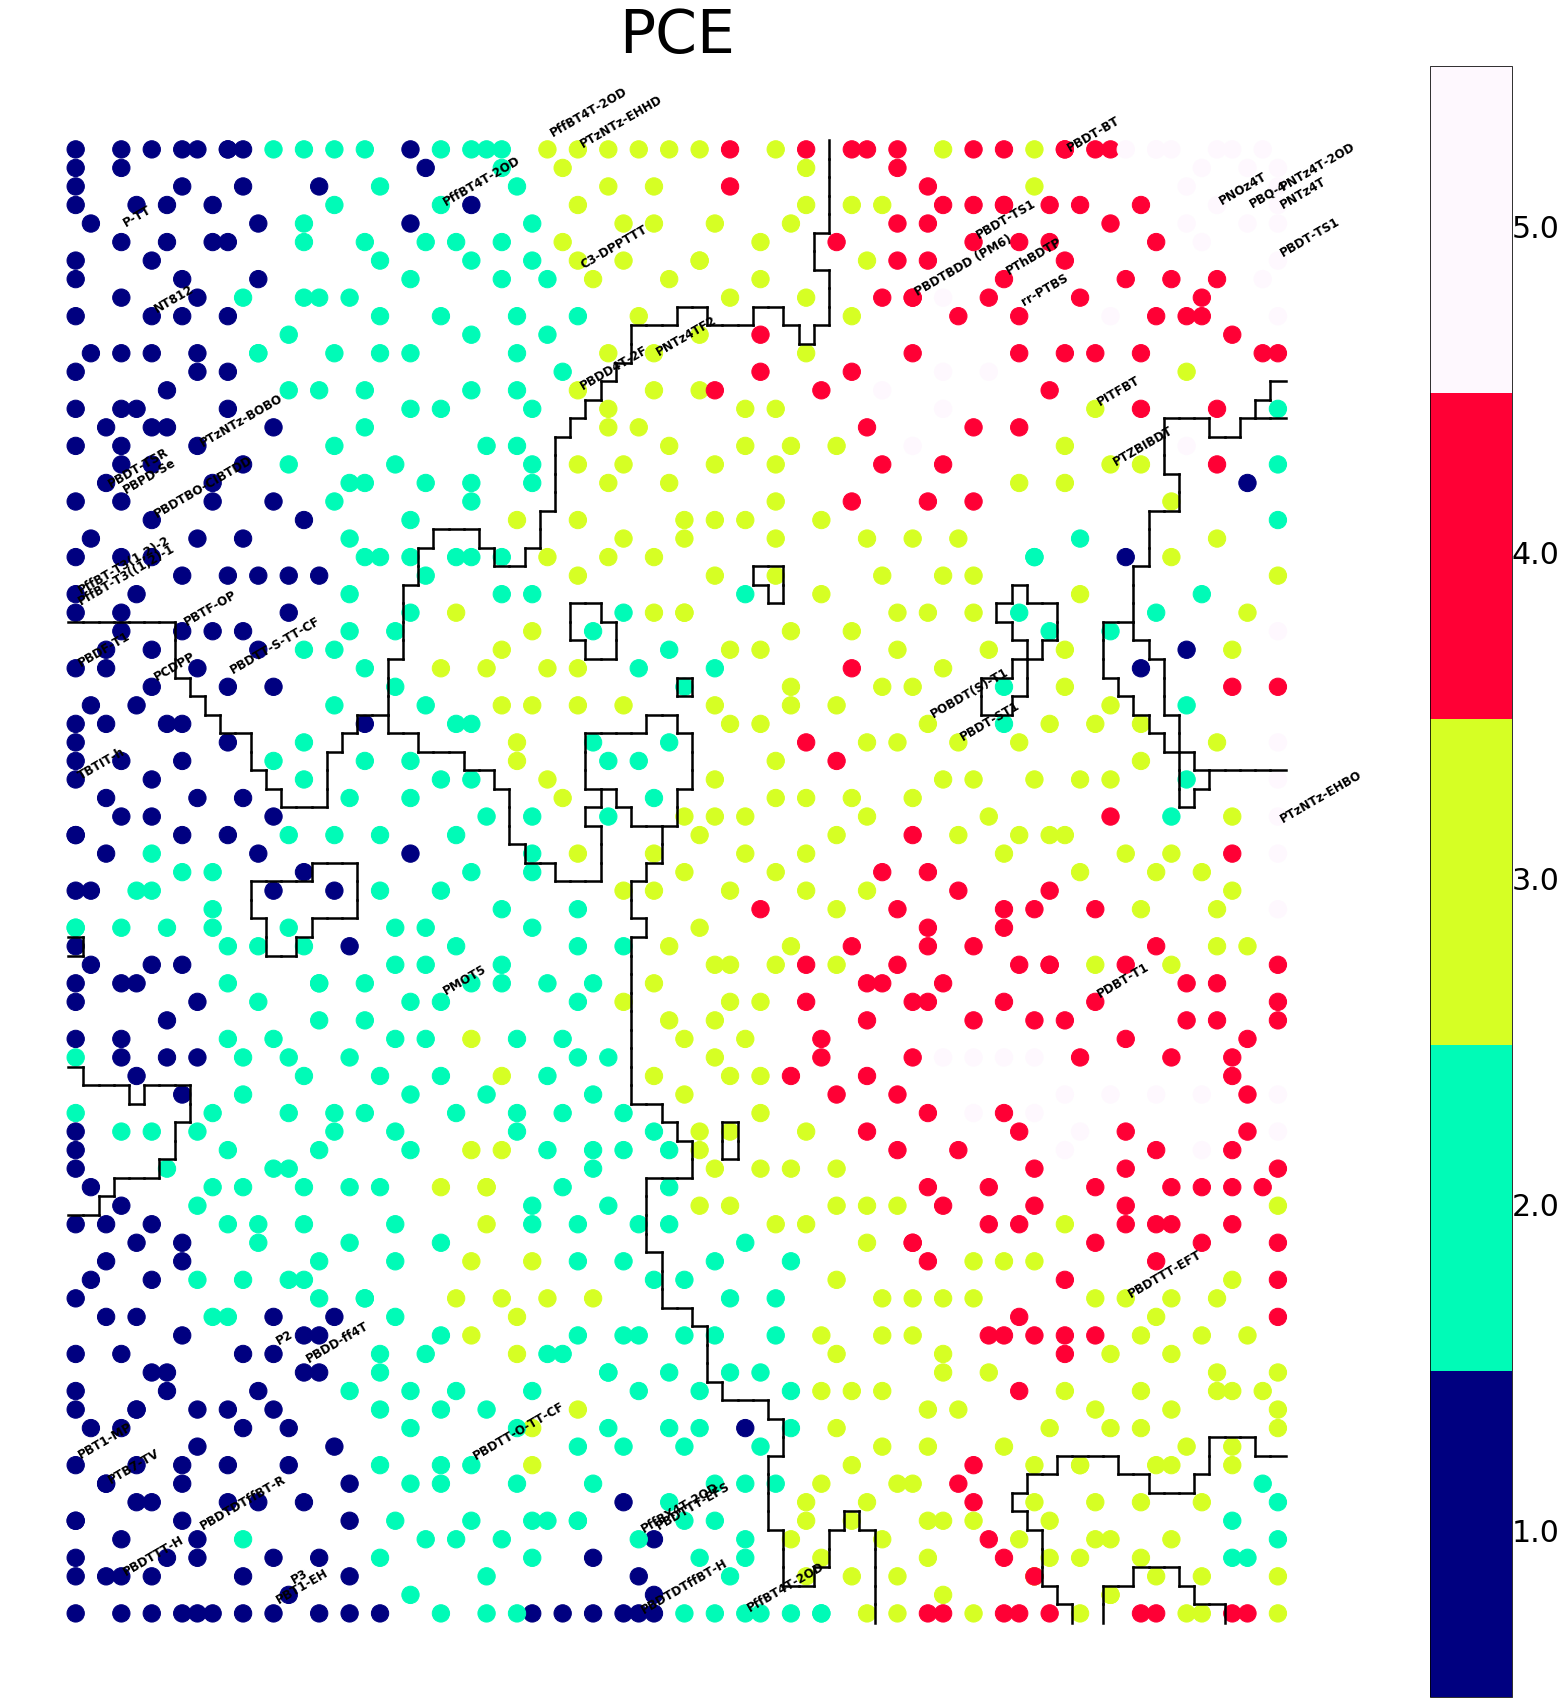

In [49]:
clusteringmap_category(sm,high_ind,4,data,"PCE_Categ",'PCE','./Images/descriptors/Mw_HOMO/PCE_Categ.png')

## Data Analysis

from the results above we can see that the Mw in the cluster on the right side of cluster map is too high that it affects the interpretation of other results. Try dropping it and then see the impact

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import AllProps
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import MolDrawing as MolDrawing
from rdkit.Chem.Draw.MolDrawing import DrawingOptions
from IPython.display import SVG
from rdkit.Chem.Draw import SimilarityMaps
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import AllChem
from rdkit.Chem import AllProps
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
from rdkit.Chem import Descriptors
from rdkit.Chem import Descriptors3D
from rdkit.Chem import MACCSkeys
from rdkit.Chem import DataStructs
import rdkit.Chem.rdMolDescriptors
from rdkit.Chem.rdMolDescriptors import Properties
from rdkit.Chem import rdMolChemicalFeatures
from rdkit.Chem import MolToMolBlock
from rdkit.Chem import Mol
from rdkit.Chem import rdmolops
from rdkit.Chem import rdMolTransforms
from rdkit.Chem import rdFMCS
from rdkit.Chem.Fingerprints import FingerprintMols

from rdkit import Geometry
from rdkit.Geometry import Point3D
from rdkit.Geometry import Point2D
import time
DrawingOptions.includeAtomNumbers = False

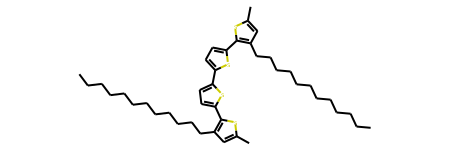

In [15]:
PQT12 = 'CCCCCCCCCCCCc1cc(C)sc1-c1ccc(-c2ccc(-c3sc(C)cc3CCCCCCCCCCCC)s2)s1'
PQT12_2 = 'CCCCCCCCCCCCc1cc(C)sc1-c1ccc(-c2ccc(-c3sc(C)cc3CCCCCCCCCCCC)s2)s1'

Chem.MolFromSmiles(PQT12)
#Chem.MolFromSmiles(PQT12)

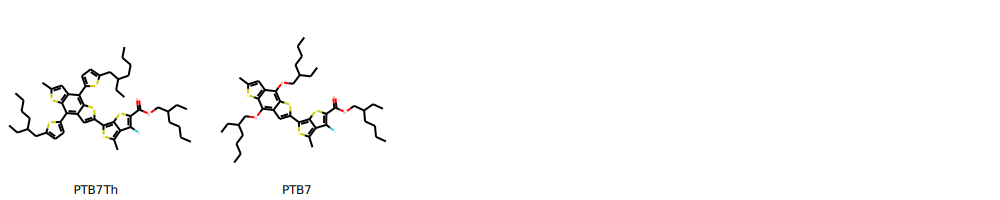

In [16]:
# PTB7Th and PTB7 have similar backboen structure but different R groups

PTB7Th = 'CCCCC(CC)COC(=O)c1sc2c(-c3cc4c(-c5ccc(CC(CC)CCCC)s5)c5sc(C)cc5c(-c5ccc(CC(CC)CCCC)s5)c4s3)sc(C)c2c1F'
PTB7 = 'CCCCC(CC)COC(=O)c1sc2c(-c3cc4c(OCC(CC)CCCC)c5sc(C)cc5c(OCC(CC)CCCC)c4s3)sc(C)c2c1F'

smis = [PTB7Th, PTB7]
Name = ["PTB7Th", "PTB7"]
mol = [Chem.MolFromSmiles(x) for x in smis]
s = Draw.MolsToGridImage(mol,molsPerRow = 5,legends = [x for x in Name],subImgSize = (200,200))
s

For same structure, higher Mw tends to give more PCE. From the view of statistics, 

In [52]:
# PTB7Th and PTB7 have similar backboen structure but different R groups
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG = True
 
def mol_with_atom_index(mol):
    atoms = mol.GetNumAtoms()
    for idx in range(atoms):
        mol.GetAtomWithIdx(idx).SetProp('molAtomMapNumber', str(mol.GetAtomWithIdx(idx).GetIdx()))
    return mol

PTB7Th = 'CCCCC(CC)COC(=O)c1sc2c(-c3cc4c(-c5ccc(CC(CC)CCCC)s5)c5sc(C)cc5c(-c5ccc(CC(CC)CCCC)s5)c4s3)sc(C)c2c1F'
PTB7 = 'CCCCC(CC)COC(=O)c1sc2c(-c3cc4c(OCC(CC)CCCC)c5sc(C)cc5c(OCC(CC)CCCC)c4s3)sc(C)c2c1F'

smis = PTB7
Name = "PTB7"
mol = Chem.MolFromSmiles(smis)
idx = [i for i in range(mol.GetNumAtoms())]
mol.GetAtomWithIdx(mol,idx)

ArgumentError: Python argument types in
    Mol.GetAtomWithIdx(Mol, Mol, list)
did not match C++ signature:
    GetAtomWithIdx(class RDKit::ROMol {lvalue}, unsigned int)

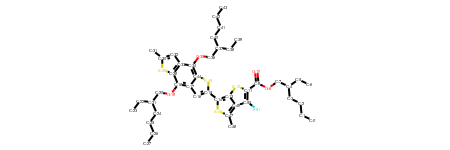

In [35]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG = True

def mol_with_atom_index(mol):
    atoms = mol.GetNumAtoms()
    for idx in range(atoms):
        mol.GetAtomWithIdx(idx).SetProp('molAtomMapNumber', str(mol.GetAtomWithIdx(idx).GetIdx()))
    return mol

mol = Chem.MolFromSmiles(PTB7)
#Default
#image = Draw.MolsToImage(mol,subImgSize=(200,200))
mol
#With index
s = mol_with_atom_index(mol)
s

In [19]:
PTB7_mol = Chem.MolFromSmiles(PTB7)
PTB7_smarts = Chem.MolToSmarts(PTB7_mol)
PTB7_smarts

'[#6]-[#6]-[#6]-[#6]-[#6](-[#6]-[#6])-[#6]-[#8]-[#6](=[#8])-[#6]1:[#16]:[#6]2:[#6](-[#6]3:[#6]:[#6]4:[#6](-[#8]-[#6]-[#6](-[#6]-[#6])-[#6]-[#6]-[#6]-[#6]):[#6]5:[#16]:[#6](-[#6]):[#6]:[#6]:5:[#6](-[#8]-[#6]-[#6](-[#6]-[#6])-[#6]-[#6]-[#6]-[#6]):[#6]:4:[#16]:3):[#16]:[#6](-[#6]):[#6]:2:[#6]:1-[#9]'

In [21]:
PTB7Th_mol = Chem.MolFromSmiles(PTB7Th)
PTB7Th_smarts = Chem.MolToSmarts(PTB7Th_mol)
PTB7Th_smarts

'[#6]-[#6]-[#6]-[#6]-[#6](-[#6]-[#6])-[#6]-[#8]-[#6](=[#8])-[#6]1:[#16]:[#6]2:[#6](-[#6]3:[#6]:[#6]4:[#6](-[#6]5:[#6]:[#6]:[#6](-[#6]-[#6](-[#6]-[#6])-[#6]-[#6]-[#6]-[#6]):[#16]:5):[#6]5:[#16]:[#6](-[#6]):[#6]:[#6]:5:[#6](-[#6]5:[#6]:[#6]:[#6](-[#6]-[#6](-[#6]-[#6])-[#6]-[#6]-[#6]-[#6]):[#16]:5):[#6]:4:[#16]:3):[#16]:[#6](-[#6]):[#6]:2:[#6]:1-[#9]'

In [26]:
smarts = '[CH2X4][#6X3]1:[$([#7X3H+,#7X2H0+0]:[#6X3H]:[#7X3H]),$([#7X3H])]:[#6X3H]:[$([#7X3H+,#7X2H0+0]:[#6X3H]:[#7X3H]),$([#7X3H])]:[#6X3H]1'

In [27]:
mol = Chem.MolFromSmarts(smarts)

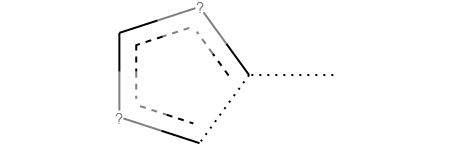

In [28]:
mol

### 4. SMARTS - A Language for Describing Molecular Patterns

Substructure searching, the process of finding a particular pattern (subgraph) in a molecule (graph), is one of the most important tasks for computers in chemistry. It is used in virtually every application that employs a digital representation of a molecule, including depiction (to highlight a particular functional group), drug design (searching a database for similar structures and activity), analytical chemistry (looking for previously-characterized structures and comparing their data to that of an unknown), and a host of other problems.

SMARTS is a language that allows you to specify substructures using rules that are straightforward extensions of SMILES. For example, to search a database for phenol-containing structures, one would use the SMARTS string [OH]c1ccccc1, which should be familiar to those acquainted with SMILES. In fact, almost all SMILES specifications are valid SMARTS targets. Using SMARTS, flexible and efficient substructure-search specifications can be made in terms that are meaningful to chemists.

In the SMILES language, there are two fundamental types of symbols: atoms and bonds. Using these SMILES symbols, once can specify a molecule's graph (its "nodes" and "edges") and assign "labels" to the components of the graph (that is, say what type of atom each node represents, and what type of bond each edge represents).

The same is true in SMARTS: One uses atomic and bond symbols to specify a graph. However, in SMARTS the labels for the graph's nodes and edges (its "atoms" and "bonds") are extended to include "logical operators" and special atomic and bond symbols; these allow SMARTS atoms and bonds to be more general. For example, the SMARTS atomic symbol [C,N] is an atom that can be aliphatic C or aliphatic N; the SMARTS bond symbol ~ (tilde) matches any bond.

Ref: https://www.daylight.com/dayhtml/doc/theory/theory.smarts.html
